In [66]:
import pandas as pd
import numpy as np

# --- Load datasets ---
train_data = pd.read_csv("datasets/CMaps/train_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv("datasets/CMaps/test_FD001.txt", sep=" ", header=None)
rul_test = pd.read_csv("datasets/CMaps/RUL_FD001.txt", header=None)

# Drop empty columns
train_data.drop(columns=[26, 27], inplace=True)
test_data.drop(columns=[26, 27], inplace=True)

# Rename columns
columns = ["unit_number", "time_cycles", "op_setting_1", "op_setting_2", "op_setting_3"] + [f"sensor_{i}" for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns

# Operator pool (7 Male, 3 Female)
operator_pool = [{"id": i, "gender": "Male"} if i <= 7 else {"id": i, "gender": "Female"} for i in range(1, 11)]

np.random.seed(42)

# Define experience levels
experience_levels = ["Intern", "Beginner", "Intermediate", "Experienced", "Expert"]

# Shift types
shift_types = ["Morning", "Afternoon", "Night"]

# --- Feature Influence Tables ---
experience_bonus = {
    "Intern": -30,
    "Beginner": -15,
    "Intermediate": 0,
    "Experienced": +15,
    "Expert": +30
}

shift_bonus = {
    "Morning": +10,
    "Afternoon": 0,
    "Night": -10
}

experience_noise = {
    "Intern": 30,
    "Beginner": 20,
    "Intermediate": 10,
    "Experienced": 7,
    "Expert": 5
}

# --- Helper Functions ---

# Assign shift based on age (mostly logical but with randomness)
def assign_shift(age):
    if age <= 30:
        return np.random.choice(["Morning", "Afternoon", "Night"], p=[0.5, 0.4, 0.1])
    elif age <= 45:
        return np.random.choice(["Morning", "Afternoon", "Night"], p=[0.4, 0.4, 0.2])
    else:
        return np.random.choice(["Morning", "Afternoon", "Night"], p=[0.2, 0.3, 0.5])

# Assign experience level based on age 
def assign_experience(age):
    if age <= 25:
        return np.random.choice(["Intern", "Beginner"], p=[0.8, 0.2])
    elif age <= 35:
        return np.random.choice(["Beginner", "Intermediate"], p=[0.3, 0.7])
    elif age <= 45:
        return np.random.choice(["Intermediate", "Experienced"], p=[0.4, 0.6])
    else:
        return np.random.choice(["Experienced", "Expert"], p=[0.3, 0.7])

# Generate human attributes
def generate_human_profile():
    age = np.random.randint(22, 61)
    shift = assign_shift(age)
    experience = assign_experience(age)
    gender = np.random.choice(["Male", "Female"], p=[0.7, 0.3])
    matching_ids = [op["id"] for op in operator_pool if op["gender"] == gender]
    operator_id = np.random.choice(matching_ids)
    return shift, operator_id, experience, age, gender

# Estimate RUL bonus
def calculate_adjustment(age, shift, experience):
    age_bonus = (age - 22) * 0.5  # Smooth age scaling
    exp_bonus = experience_bonus[experience]
    shift_adj = shift_bonus[shift]
    total_bonus = age_bonus + exp_bonus + shift_adj
    noise = np.random.normal(0, experience_noise[experience])
    return total_bonus + noise

# --- Process Train Data ---
max_cycles_train = train_data.groupby("unit_number")["time_cycles"].transform("max")
virtual_rul_train = max_cycles_train - train_data["time_cycles"]

train_profiles = []
for rul in virtual_rul_train:
    shift, operator_id, experience, age, gender = generate_human_profile()
    adjusted_rul = rul + calculate_adjustment(age, shift, experience)
    adjusted_rul = np.clip(adjusted_rul, 1, 300)  # Prevent weird values
    train_profiles.append((shift, operator_id, experience, age, gender, adjusted_rul))

train_profiles_df = pd.DataFrame(train_profiles, columns=["shift_type", "operator_id", "experience_level", "age", "gender", "adjusted_rul"])
train_final = pd.concat([train_data, train_profiles_df.drop(columns=["adjusted_rul"])], axis=1)
train_final["adjusted_rul"] = train_profiles_df["adjusted_rul"]

# --- Process Test Data ---
test_last_cycles = test_data.groupby("unit_number")["time_cycles"].max().reset_index()
test_last_cycles["RUL"] = rul_test
test_data = test_data.merge(test_last_cycles, on=["unit_number", "time_cycles"], how="left")
test_data["RUL"] = test_data.groupby("unit_number")["RUL"].ffill()

test_profiles = []
for rul in test_data["RUL"]:
    shift, operator_id, experience, age, gender = generate_human_profile()
    adjusted_rul = rul + calculate_adjustment(age, shift, experience)
    adjusted_rul = np.clip(adjusted_rul, 1, 300)
    test_profiles.append((shift, operator_id, experience, age, gender, adjusted_rul))

test_profiles_df = pd.DataFrame(test_profiles, columns=["shift_type", "operator_id", "experience_level", "age", "gender", "adjusted_rul"])
test_final = pd.concat([test_data.drop(columns=["RUL"]), test_profiles_df.drop(columns=["adjusted_rul"])], axis=1)
test_final["adjusted_rul"] = test_profiles_df["adjusted_rul"]

# --- Save Outputs ---
train_final.to_csv("datasets/shift-data/train_FD001_with_humans.csv", index=False)
test_final.to_csv("datasets/shift-data/test_FD001_with_humans.csv", index=False)

print("Synthetic datasets saved successfully!")


Synthetic datasets saved successfully!


In [67]:
import pandas as pd


train = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")
test = pd.read_csv("datasets/shift-data/test_FD001_with_humans.csv")


summary = {
    "train_preview": train.head(5),
    "test_preview": test.head(5),
    "train_gender_distribution": train["gender"].value_counts(normalize=True),
    "test_gender_distribution": test["gender"].value_counts(normalize=True),
    "train_shift_distribution": train["shift_type"].value_counts(),
    "test_shift_distribution": test["shift_type"].value_counts(),
    "train_experience_levels": train["experience_level"].value_counts(),
    "test_experience_levels": test["experience_level"].value_counts(),
    "train_age_range": (train["age"].min(), train["age"].max()),
    "test_age_range": (test["age"].min(), test["age"].max()),
}

summary


{'train_preview':    unit_number  time_cycles  op_setting_1  op_setting_2  op_setting_3  \
 0            1            1       -0.0007       -0.0004         100.0   
 1            1            2        0.0019       -0.0003         100.0   
 2            1            3       -0.0043        0.0003         100.0   
 3            1            4        0.0007        0.0000         100.0   
 4            1            5       -0.0019       -0.0002         100.0   
 
    sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_18  \
 0    518.67    641.82   1589.70   1400.60     14.62  ...       2388   
 1    518.67    642.15   1591.82   1403.14     14.62  ...       2388   
 2    518.67    642.35   1587.99   1404.20     14.62  ...       2388   
 3    518.67    642.35   1582.79   1401.87     14.62  ...       2388   
 4    518.67    642.37   1582.85   1406.22     14.62  ...       2388   
 
    sensor_19  sensor_20  sensor_21  shift_type  operator_id  experience_level  \
 0      100.0      39

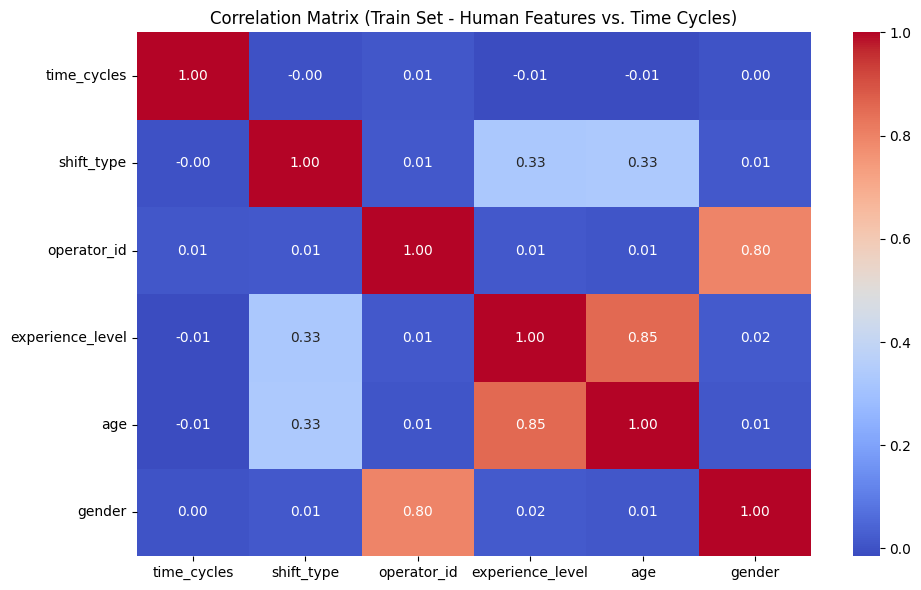

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt


train_encoded = train.copy()
train_encoded["gender"] = train_encoded["gender"].map({"Male": 0, "Female": 1})
train_encoded["shift_type"] = train_encoded["shift_type"].map({"Morning": 0, "Afternoon": 1, "Night": 2})
train_encoded["experience_level"] = train_encoded["experience_level"].map({
    "Beginner": 0, "Intermediate": 1, "Expert": 2
})

correlation_matrix = train_encoded[["time_cycles", "shift_type", "operator_id", "experience_level", "age", "gender"]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Train Set - Human Features vs. Time Cycles)")
plt.tight_layout()
plt.show()


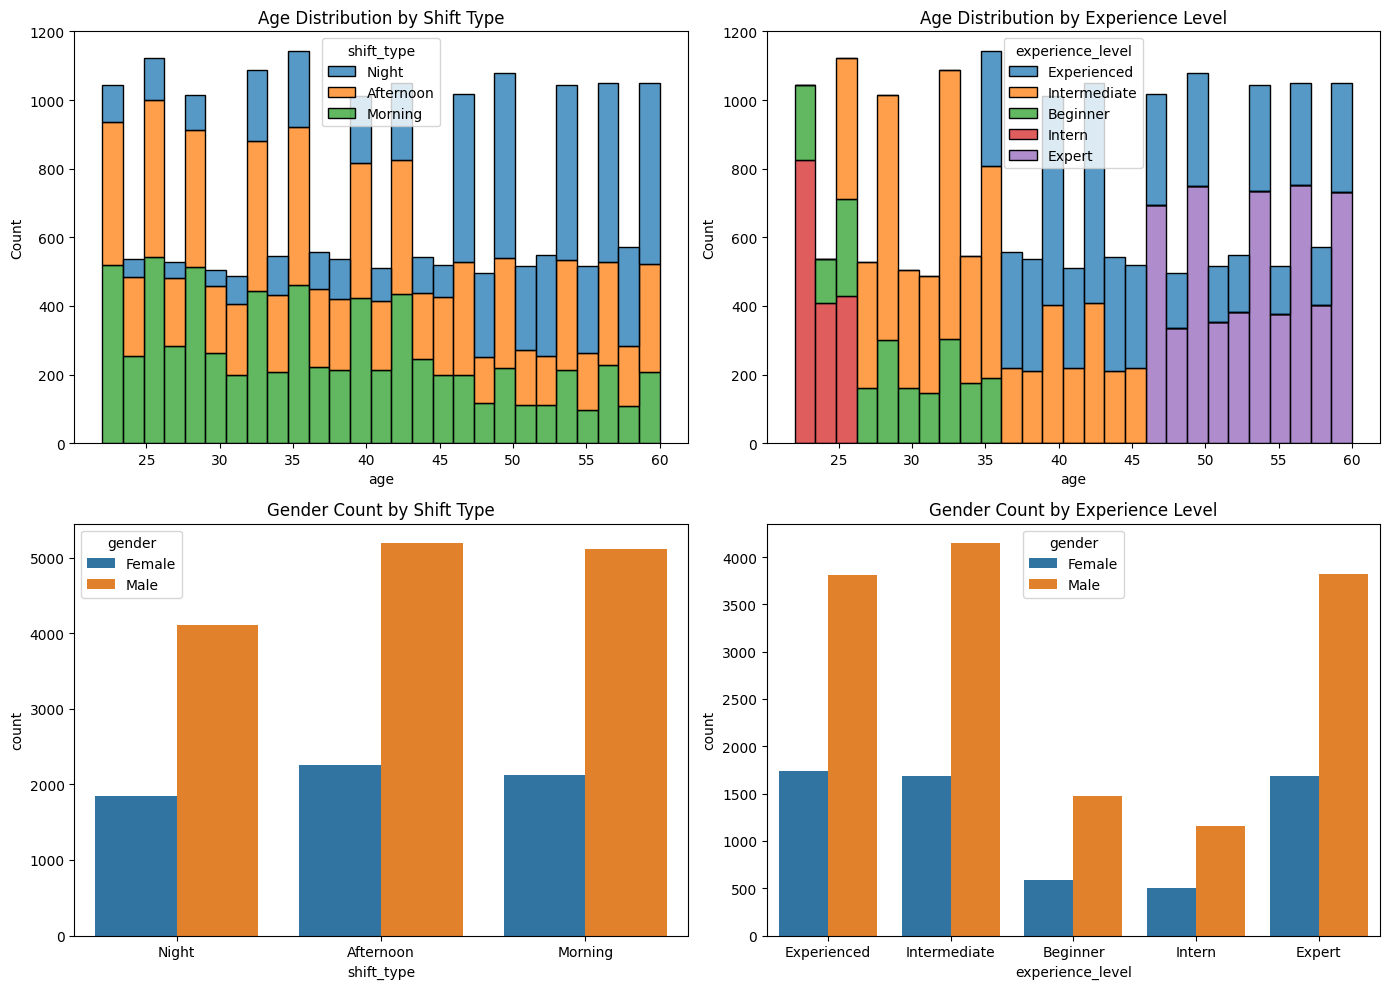

In [69]:

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(data=train, x="age", hue="shift_type", multiple="stack", ax=axs[0, 0])
axs[0, 0].set_title("Age Distribution by Shift Type")

sns.histplot(data=train, x="age", hue="experience_level", multiple="stack", ax=axs[0, 1])
axs[0, 1].set_title("Age Distribution by Experience Level")

sns.countplot(data=train, x="shift_type", hue="gender", ax=axs[1, 0])
axs[1, 0].set_title("Gender Count by Shift Type")

sns.countplot(data=train, x="experience_level", hue="gender", ax=axs[1, 1])
axs[1, 1].set_title("Gender Count by Experience Level")

plt.tight_layout()
plt.show()


# Random Forest

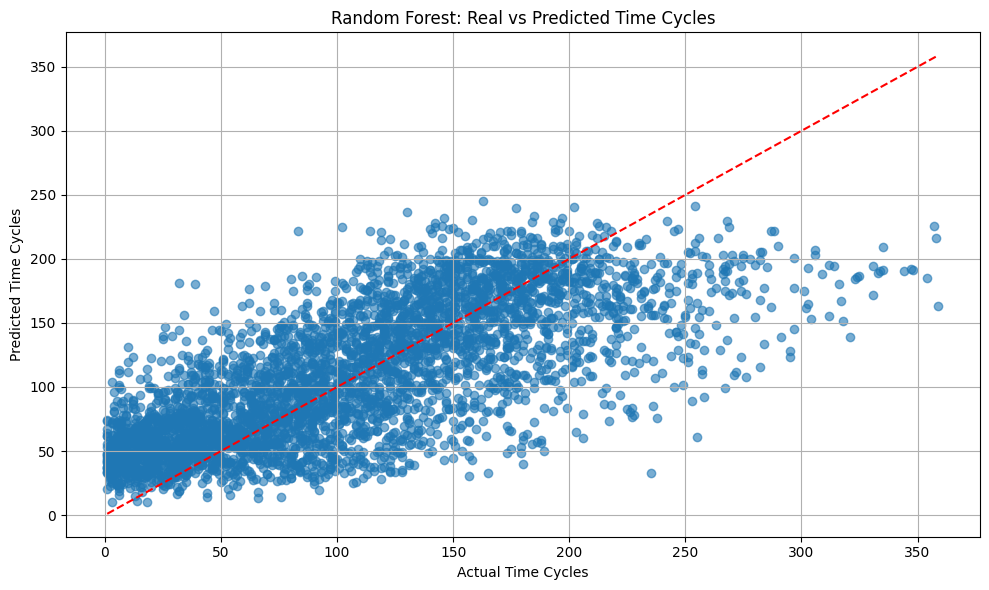

(np.float64(47.13770990259196), 36.50617833130712, 0.5263106896383768)

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


drop_columns = [
    "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

X = train.drop(columns=drop_columns + ["time_cycles", "unit_number"])
y = train["time_cycles"] 

X_encoded = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)


X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_val)


rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Time Cycles")
plt.ylabel("Predicted Time Cycles")
plt.title("Random Forest: Real vs Predicted Time Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

rmse, mae, r2


# Gradient Boosting

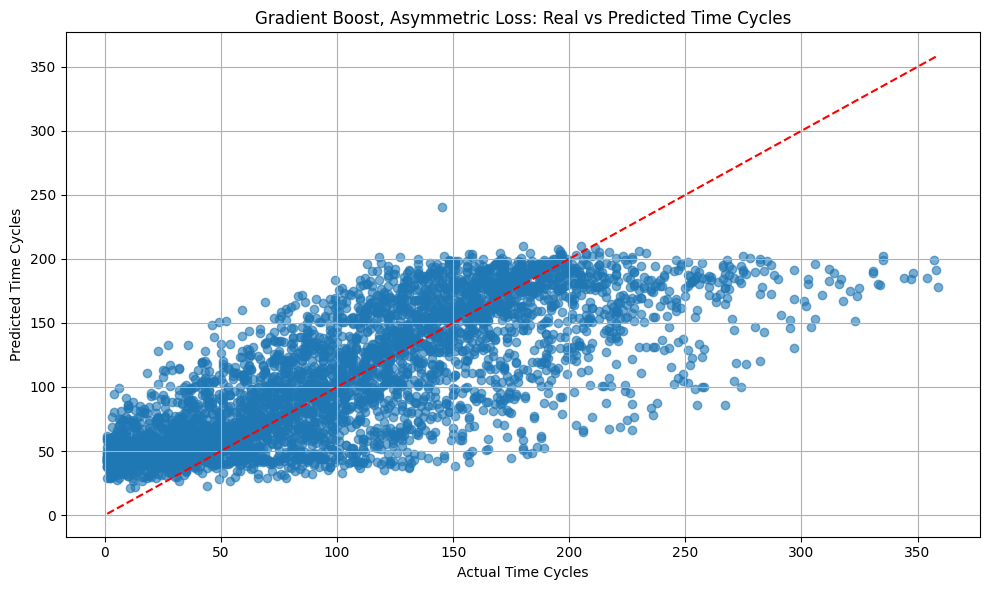

(np.float64(52.12628864033915), 33.96270962207072, 0.5774627227556162)

In [71]:
from sklearn.ensemble import GradientBoostingRegressor


gbr_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
gbr_model.fit(X_train, y_train)


y_pred_gbr = gbr_model.predict(X_val)


errors = y_pred_gbr - y_val
asymmetric_errors = np.where(errors > 0, 2 * (errors ** 2), errors ** 2)
rmse = np.sqrt(np.mean(asymmetric_errors))
mae = mean_absolute_error(y_val, y_pred_gbr)
r2 = r2_score(y_val, y_pred_gbr)


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_gbr, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Time Cycles")
plt.ylabel("Predicted Time Cycles")
plt.title("Gradient Boost, Asymmetric Loss: Real vs Predicted Time Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

rmse, mae, r2


# Linear Regression

(np.float64(46.333476220255804), 35.97706938066627, 0.5423363759415859)

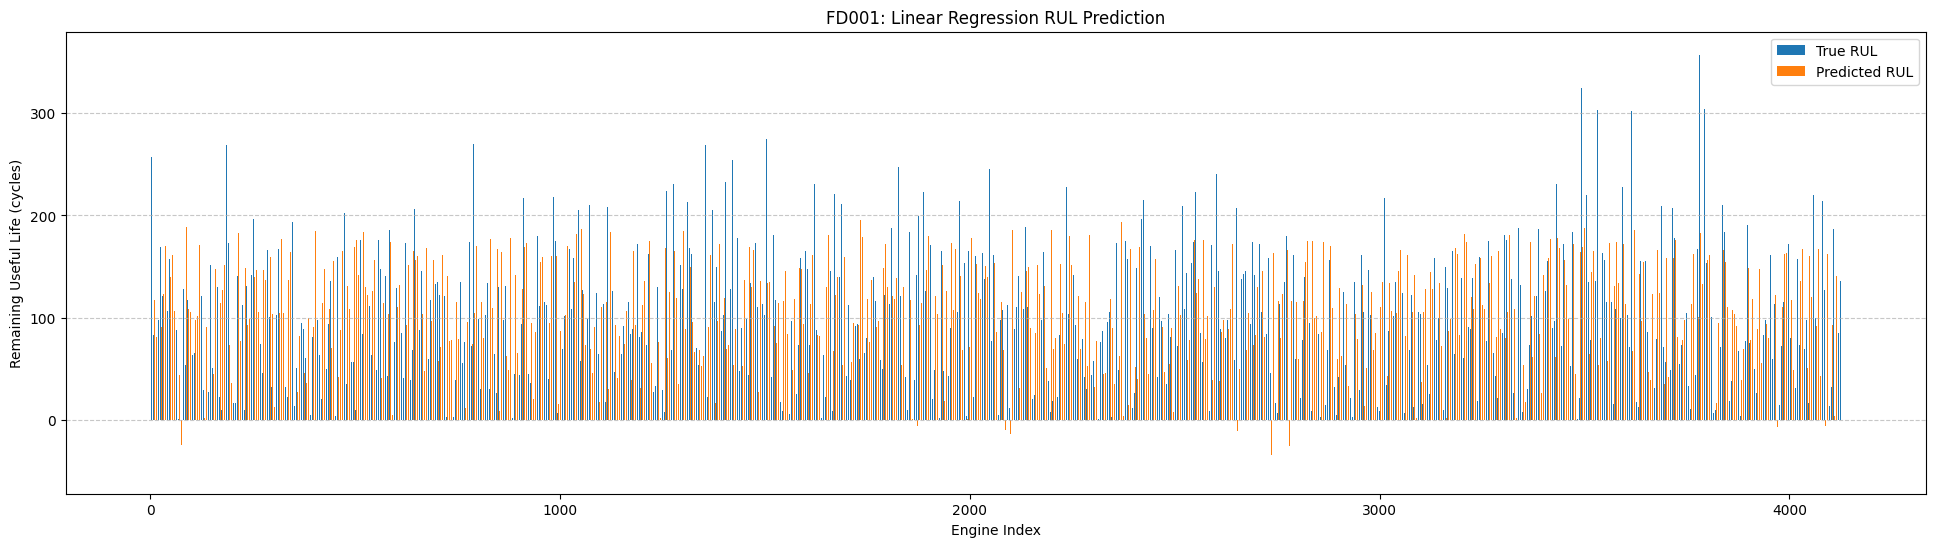

In [72]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


y_pred_lr = lr_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2 = r2_score(y_val, y_pred_lr)


plt.figure(figsize=(24, 6))
bar_width = 0.3
indices = np.arange(len(y_val))
plt.bar(indices - bar_width/2, y_val.values, bar_width, label='True RUL', color='#1f77b4')
plt.bar(indices + bar_width/2, y_pred_lr, bar_width, label='Predicted RUL', color='#ff7f0e')

plt.xlabel("Engine Index")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title("FD001: Linear Regression RUL Prediction")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout
rmse, mae, r2

# MLP

Epoch 1, Train Loss: 8533.89, Val Loss: 2256.26
Epoch 2, Train Loss: 2451.33, Val Loss: 2014.38
Epoch 3, Train Loss: 2384.33, Val Loss: 1997.37
Epoch 4, Train Loss: 2361.68, Val Loss: 2004.10
Epoch 5, Train Loss: 2356.53, Val Loss: 1998.90
Epoch 6, Train Loss: 2337.36, Val Loss: 1994.56
Epoch 7, Train Loss: 2335.63, Val Loss: 1982.08
Epoch 8, Train Loss: 2299.13, Val Loss: 1981.65
Epoch 9, Train Loss: 2337.14, Val Loss: 1979.51
Epoch 10, Train Loss: 2307.00, Val Loss: 1978.59
Epoch 11, Train Loss: 2313.71, Val Loss: 1986.93
Epoch 12, Train Loss: 2311.15, Val Loss: 1977.54
Epoch 13, Train Loss: 2288.07, Val Loss: 1977.97
Epoch 14, Train Loss: 2310.05, Val Loss: 1978.16
Epoch 15, Train Loss: 2295.22, Val Loss: 1981.43
Epoch 16, Train Loss: 2292.21, Val Loss: 1980.41
Epoch 17, Train Loss: 2316.36, Val Loss: 1974.20
Epoch 18, Train Loss: 2287.79, Val Loss: 1984.55
Epoch 19, Train Loss: 2276.52, Val Loss: 1976.50
Epoch 20, Train Loss: 2281.06, Val Loss: 1974.80
Epoch 21, Train Loss: 2292.65

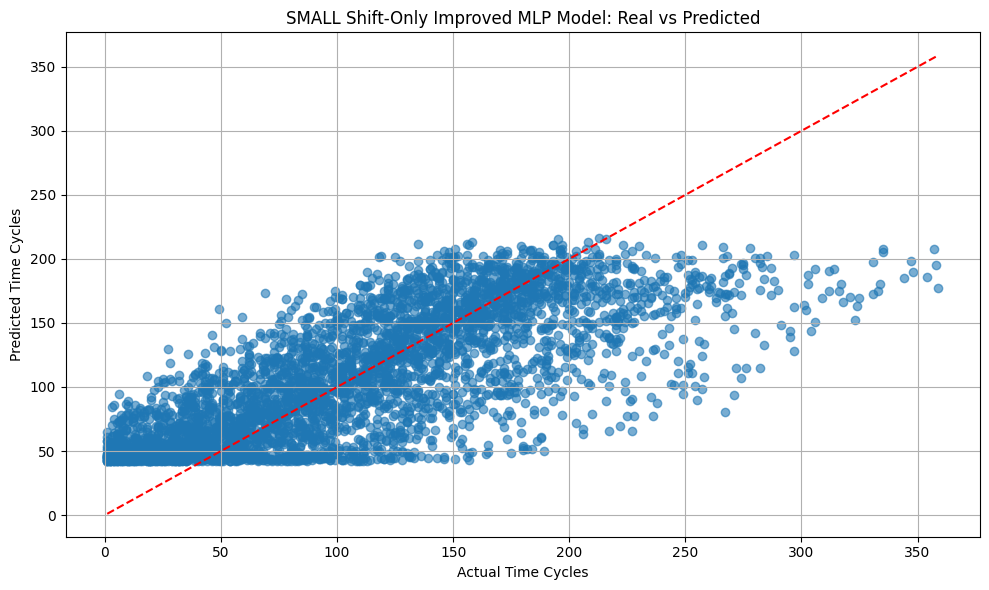

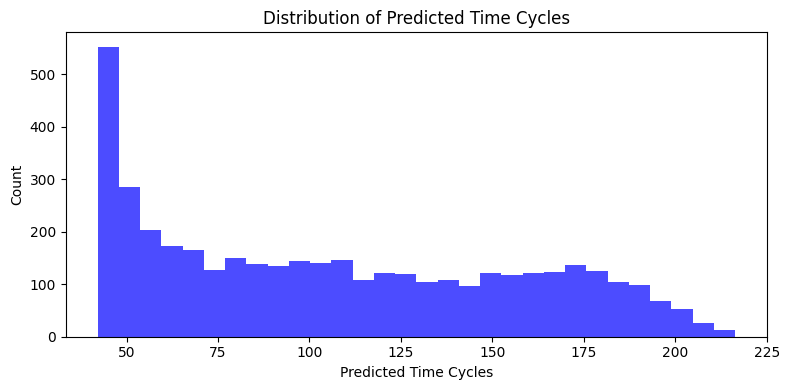

In [73]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# --- Load dataset ---
df = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")
drop_columns = ["op_setting_1", "op_setting_2", "op_setting_3"] + [f"sensor_{i}" for i in range(1, 22)]
X = df.drop(columns=drop_columns + ["time_cycles", "unit_number"])
y = df["time_cycles"]

# --- Encode and scale ---
X = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Dataset ---
class ShiftDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(-1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ShiftDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(ShiftDataset(X_val, y_val), batch_size=64)

# --- Model ---
class ImprovedMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedMLP(X.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# --- Train loop ---
best_loss = float("inf")
patience, wait = 40, 0

for epoch in range(300):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")

    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

# --- Evaluate ---
model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy().flatten()
        preds.extend(pred)
        targets.extend(yb.numpy().flatten())

mae = mean_absolute_error(targets, preds)
rmse = np.sqrt(mean_squared_error(targets, preds))
r2 = r2_score(targets, preds)
print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(targets, preds, alpha=0.6)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
plt.xlabel("Actual Time Cycles")
plt.ylabel("Predicted Time Cycles")
plt.title("SMALL Shift-Only Improved MLP Model: Real vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
plt.hist(preds, bins=30, color="blue", alpha=0.7)
plt.xlabel("Predicted Time Cycles")
plt.ylabel("Count")
plt.title("Distribution of Predicted Time Cycles")
plt.tight_layout()
plt.show()


## Results

This model predicts engine Remaining Useful Life (RUL) using only synthetic human-related features (shift type, experience level, age, gender).  
Despite limited inputs, the MLP achieved MAE ~33.7, RMSE ~44.4, and R² ~0.58, showing that human factors give a meaningful but partial prediction signal.  
The synthetic dataset was designed to keep a realistic but slightly randomized correlation between human profiles and RUL.
